### 一.原理
整图预测是针对图层面的学习任务，比如判断某药物分子是否具有某种理化性质，再比如判断某社团是否具有欺诈可能，这需要我们对整个图提取它的特征表示，然后再基于此构建我们的学习任务，图的整体特征无外乎来源于三部分：1）节点特征；2）边特征；3）结构信息，基于这些信息，我们可以通过许多方式来构建图特征，DGL提供了一些简单的API，比如对各节点特征求和/求平均/pooling等，这可以方便我们构建一些基准图预测模型，下面我们利用对节点特征求平均的方式构建图特征，这可以通过`dgl.mean_nodes`这个API很方便的实现，它相当于做了如下计算：    

$$
h_g=\frac{1}{|V|}\sum_{v\in V }h_v
$$  

$h_v$表示节点$v$的特征，然后基于$h_g$特征向量，构建我们预测模型

### 二.实现  
利用dgl自带的MiniGCDataset数据集，它包括如下的8种类别的图结构   
![avatar](./pic/MiniGCDataset.png)

Using backend: pytorch


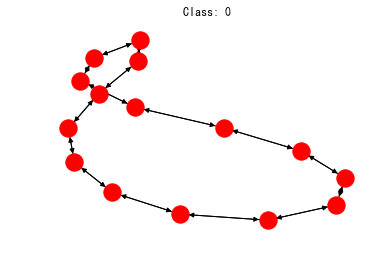

In [1]:
#1.导入数据
import dgl
import torch
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
#这里，随机构造了80个图，每个图是少10条边，最多30条边
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]

#绘制图像
%matplotlib inline
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

In [2]:
#2.定义模型
from dgl.nn.pytorch import GraphConv
import torch.nn.functional as F
from torch import nn
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)#线性分类器
        
    def forward(self, g):
        # 以节点度作为初始节点特征。对于无向图，入度与外度相同。
        h = g.in_degrees().view(-1, 1).float()
        # 执行图形卷积和激活函数
        h = F.relu(self.conv1(g,h))
        h = F.relu(self.conv2(g,h))
        g.ndata['h'] = h
        
        # 通过对所有节点表示求平均来计算图形表示。
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

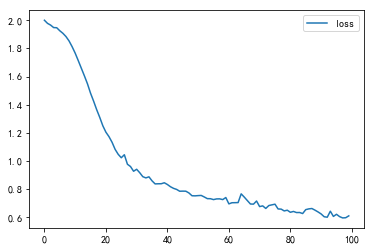

In [3]:
#3.训练
import torch.optim as optim
from torch.utils.data import DataLoader

# 将多张图合并为一张图
def collate(samples):
    # The input `samples` is a list of pairs (graph, label).
    graphs, labels = map(list, zip(*samples)) #把一批图 zip成 列表对象
    batched_graph = dgl.batch(graphs)#合并为一张图
    return batched_graph, torch.tensor(labels)


# 训练集/测试集
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)

#batch训练
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

# 构建模型
model = Classifier(1, 256, trainset.num_classes)

loss_func = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
epoch_losses = []

for epoch in range(100):
    epoch_loss = 0
    for i, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (i + 1)
#     print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

plt.plot(epoch_losses)
plt.legend(["loss"])

In [4]:
#4.测试
model.eval()
test_X, test_Y = map(list, zip(*testset))

test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)

pred_Y = torch.max(model(test_bg), 1)[1].view(-1, 1)

print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == pred_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of argmax predictions on the test set: 72.500000%


In [5]:
#5.查看混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(test_Y, pred_Y)

array([[10,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  5,  0,  0,  3,  2,  0,  0],
       [ 0,  0, 10,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  7,  0,  0,  3,  0],
       [ 0,  0,  3,  0,  0,  0,  0,  7],
       [ 0,  0,  0,  0,  2,  6,  0,  2],
       [ 0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10]], dtype=int64)